Catcher Framing References

[1] https://www.baseballprospectus.com/news/article/25514/moving-beyond-wowy-a-mixed-approach-to-measuring-catcher-framing/
[2] https://www.fangraphs.com/blogs/pitch-framing-data-is-going-insane/

The gold-standard BP model "CSAA" (Called Strikes Above Average) is outlined in [1]. This is a mixed effects model which uses modelled called strike probability (cs_prob) and half-innging (half) as fixed effects, while adjusting for catcher, pitcher, umpire, batter, and catcher:cs_prob interaction as the random effects. The random effects are modelled as such because they are assumed to be dependent - the impact of the individual catcher is modulated by the pitcher, umpire, batter, and cs_prob, and the other individual impact of each variable is modulated by the other random effects variables in the same way. These random effects have are assumed to have a linear contribution to the likelihood of a strike. 



In [512]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm, ensemble

np.random.seed(5)
random_seed = np.random.randint(0,10000)
random_seed

2915

In [513]:
filepath = '/Users/dangoldberg/Desktop/DataScienceInterviewProjects/Toronto Blue Jays/catcherframe.csv'

In [514]:
df = pd.read_csv(filepath)

In [515]:
df.columns

Index(['parkid', 'bluejaysgameid', 'gamepitchsequence', 'half', 'balls',
       'strikes', 'pitcherid', 'pitcherhand', 'batterid', 'batside',
       'catcherid', 'pitchtype', 'relspeed', 'hbreak', 'vbreak', 'plate_x',
       'plate_z', 'calledstrike', 'ball', 'swings', 'takes', 'pitchout',
       'intentball', 'inplay', 'pitcheventtype', 'hbp', 'ump_hp'],
      dtype='object')

In [516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342506 entries, 0 to 342505
Data columns (total 27 columns):
parkid               342506 non-null int64
bluejaysgameid       342506 non-null object
gamepitchsequence    342506 non-null int64
half                 342506 non-null int64
balls                342506 non-null int64
strikes              342506 non-null int64
pitcherid            342506 non-null int64
pitcherhand          342506 non-null object
batterid             342506 non-null int64
batside              342506 non-null object
catcherid            342506 non-null int64
pitchtype            342506 non-null object
relspeed             342506 non-null float64
hbreak               342506 non-null float64
vbreak               342506 non-null float64
plate_x              342506 non-null float64
plate_z              342506 non-null float64
calledstrike         342506 non-null int64
ball                 342506 non-null int64
swings               342506 non-null int64
takes          

In [517]:

# impute missing ump ids as -1
df['ump_hp'] = df['ump_hp'].replace(np.nan, -1).astype(str)

In [522]:
# only look at called strikes for framing

data = df[(df['swings'] == 0) & (df['intentball'] == 0)]

In [523]:
#feature engineering

base_columns = [
    'strikes',
    'balls',
    'batside',
    'pitcherhand',
    'pitchtype',
    'ump_hp',
    'relspeed',
    'plate_x',
    'plate_z',
    'hbreak',
    'vbreak'
]

categoricals = [
    'count_state',
    'batside',
    'pitchtype',
    'pitcherhand',
    'ump_hp'
]

continuous = [
    'relspeed',
    'plate_x',
    'plate_z',
    'hbreak',
    'vbreak'
]

labels = data['calledstrike']
data.drop('calledstrike', axis=1, inplace=True)
data = data[base_columns]

data['count_state'] = data.apply(lambda df: str(df['balls']) + str(df['strikes']), axis=1)


# one-hot-encoding of count state
# one-hot-encoding of pitcherhand
# one-hot-encoding of batside
# one-hot-encoding of pitchtype
# one-hot-encoding of ump

one_hot_encoder = preprocessing.OneHotEncoder(sparse=False).fit(data[categoricals])
cat_df = pd.DataFrame(one_hot_encoder.transform(data[categoricals]))
cat_df.columns = one_hot_encoder.get_feature_names(categoricals)
data = data.reset_index(drop=True).merge(cat_df, how='inner', left_index=True, right_index=True)
labels = labels.reset_index(drop=True)
data.drop(categoricals, axis=1, inplace=True)

print(data.shape, labels.shape)

(182944, 95) (182944,)


# Try some simple models

In [524]:
def train_and_score_classifier(clf, data, lables, frac=1.0):
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.16, random_state=random_seed)

    # standard-scale continuous variables
    scaler = preprocessing.StandardScaler().fit(X_train[continuous])
    X_train, X_test = preprocess_after_split(X_train,scaler), preprocess_after_split(X_test,scaler)

    # use smaller dataset to test iteration
    X_train, y_train = use_train_subset(X_train, y_train, frac=frac)
    
    # train model
    clf.fit(X_train, y_train)
    return clf.score(X_train, y_train), clf.score(X_test,y_test), clf, scaler
    
def preprocess_after_split(X, scaler):
    X.loc[:,continuous] = scaler.transform(X[continuous])
    return X

def use_train_subset(X, y, frac):
    sample_index = X.sample(frac=frac).index
    X = X.loc[sample_index]
    y = y.loc[sample_index]
    return X, y



In [17]:
models = {}

RBF Support Vector Machine

In [62]:
c_params = np.logspace(-1, 2, 4)

models = models['svc']:{}
for c in c_params:
    clf = svm.SVC(C=c)
    train_score, test_score, clf, _ = train_and_score_classifier(clf, data, labels, frac=0.1)
    models['svc'][c] = {'train_score':train_score, 'test_score':test_score, 'clf':clf}
models

SyntaxError: invalid syntax (<ipython-input-62-d167ef657006>, line 3)

Random Forest

In [74]:
max_depth_params = np.logspace(1, 4, 4)

models['rf'] = {}
for max_depth in max_depth_params:
    clf = ensemble.RandomForestClassifier(max_depth=max_depth, n_estimators=100)
    train_score, test_score, clf, _ = train_and_score_classifier(clf, data, labels, frac=0.66)
    models['rf'][max_depth] = {'train_score':train_score, 'test_score':test_score, 'clf':clf}

models

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

{'rf': {10.0: {'train_score': 0.8567597412841143,
   'test_score': 0.8526919923476359,
   'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=10.0, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)},
  100.0: {'train_score': 1.0,
   'test_score': 0.904892047007379,
   'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=100.0, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, r

In [84]:
cal_data = data.copy()

cal_data.loc[:,continuous] = preprocessing.StandardScaler().fit(cal_data[continuous]).transform(cal_data[continuous])
models['rf'][100]['clf'].score(cal_data,labels)

0.9581073989854819

In [526]:
from sklearn import calibration

def plot_calibration_curve(labels, proba, n_bins=10):
    prob_true, prob_pred = calibration.calibration_curve(labels, proba, normalize=False, n_bins=10)
    plt.plot(prob_pred,prob_true)
    #plt.hist(prob_pred, bins=10)
    plt.show()

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


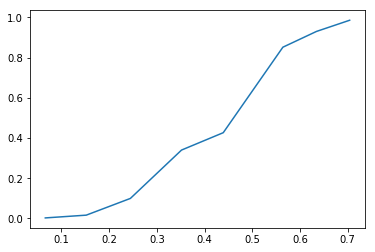

In [527]:
model = ensemble.RandomForestClassifier(max_depth=10, n_estimators=100)
train_score, test_score, model, scaler = train_and_score_classifier(model, data, labels, frac=1.0)

cal_data = data.copy()
cal_data.loc[:,continuous] = preprocessing.StandardScaler().fit(cal_data[continuous]).transform(cal_data[continuous])

proba = model.predict_proba(cal_data)[:,1]
preds = model.predict(cal_data)
plot_calibration_curve(labels, proba, n_bins=10)

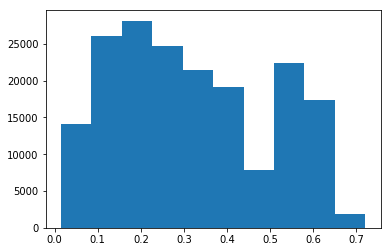

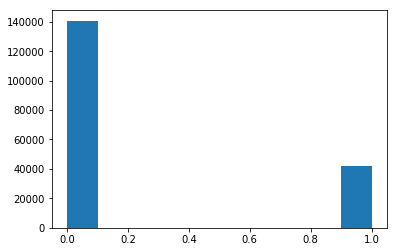

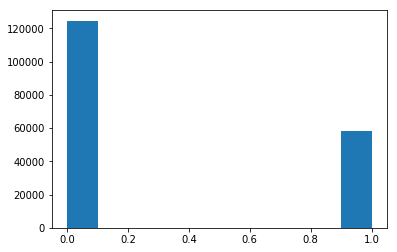

In [528]:
plt.hist(proba)
plt.show()
plt.hist(preds)
plt.show()
plt.hist(labels)
plt.show()

## Calibrate the Model Probabilities

In [98]:
clf = calibration.CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit')

In [99]:
clf.fit(cal_data, labels)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv='prefit', method='isotonic')

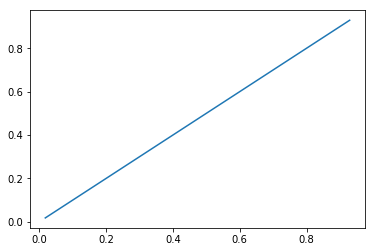

In [100]:
proba = clf.predict_proba(cal_data)[:,1]
preds = clf.predict(cal_data)
plot_calibration_curve(labels, proba, n_bins=10)

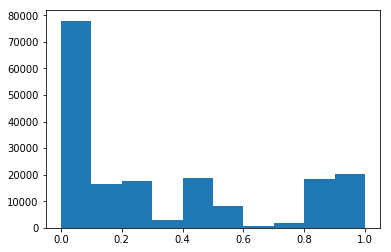

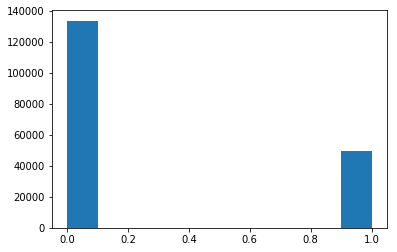

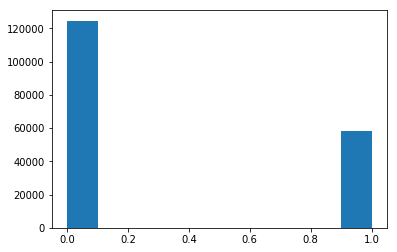

In [102]:
plt.hist(proba)
plt.show()
plt.hist(preds)
plt.show()
plt.hist(labels)
plt.show()

In [169]:

data = df[(df['swings'] == 0) & (df['intentball'] == 0)]
data.loc[:,'cs_prob'] = proba


NameError: name 'proba' is not defined

In [113]:
data.to_csv('data_with_cs_prob.csv',index=False)

In [536]:
feature_importances = pd.DataFrame(model.feature_importances_)
feature_importances.index = data.columns
feature_importances.columns = ['feature_importance']

feature_importances.sort_values('feature_importance', ascending = False)

,feature_importance
plate_z,0.396590
plate_x,0.288851
strikes,0.116164
count_state_00,0.048437
count_state_02,0.020186
count_state_12,0.017367
count_state_30,0.012802
balls,0.010933
count_state_10,0.009162
count_state_22,0.009150


# Apply Generalized Linear Mixed Effects Model

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [170]:
filepath = 'data_with_cs_prob.csv'

In [171]:
df = pd.read_csv(filepath)

In [172]:
df[:5]

,parkid,bluejaysgameid,gamepitchsequence,half,balls,strikes,pitcherid,pitcherhand,batterid,batside,...,ball,swings,takes,pitchout,intentball,inplay,pitcheventtype,hbp,ump_hp,cs_prob
0,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,1,0,0,0,11198,R,171109,R,...,1,0,1,0,0,0,ball,0,142393.0,0.445767
1,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,2,0,1,0,11198,R,171109,R,...,0,0,1,0,0,0,called_strike,0,142393.0,0.808174
2,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,3,0,1,1,11198,R,171109,R,...,1,0,1,0,0,0,ball,0,142393.0,0.008856
3,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,6,0,2,2,11198,R,171109,R,...,1,0,1,0,0,0,ball,0,142393.0,0.021135
4,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,8,0,0,0,11198,R,7327,R,...,1,0,1,0,0,0,ball,0,142393.0,0.865428


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182944 entries, 0 to 182943
Data columns (total 28 columns):
parkid               182944 non-null int64
bluejaysgameid       182944 non-null object
gamepitchsequence    182944 non-null int64
half                 182944 non-null int64
balls                182944 non-null int64
strikes              182944 non-null int64
pitcherid            182944 non-null int64
pitcherhand          182944 non-null object
batterid             182944 non-null int64
batside              182944 non-null object
catcherid            182944 non-null int64
pitchtype            182944 non-null object
relspeed             182944 non-null float64
hbreak               182944 non-null float64
vbreak               182944 non-null float64
plate_x              182944 non-null float64
plate_z              182944 non-null float64
calledstrike         182944 non-null int64
ball                 182944 non-null int64
swings               182944 non-null int64
takes          

In [174]:
import statsmodels
from scipy.stats import norm


In [124]:
random = {
    'parkid':'C(parkid)',
    'ump_hp':'C(ump_hp)',
    'pitcherid':'C(pitcherid)',
    'batterid':'C(batterid)',
    'catcherid':'C(catcherid)',
    'catcherid:cs_prob':'C(catcherid):cs_prob'
}

model = sm.BinomialBayesMixedGLM.from_formula('calledstrike ~ cs_prob + C(half)', random, df)

# change to probit link function

link = statsmodels.genmod.families.links.probit()
family = sm.genmod.families.family.Binomial(link=link)

model.family = family

In [ ]:
model_fitted = model.fit_vb()

In [127]:
print(model_fitted.summary())

                   Binomial Mixed GLM Results
                  Type Post. Mean Post. SD   VC  VC (LB) VC (UB)
----------------------------------------------------------------
Intercept            F    -3.1023   0.0075                      
C(half)[T.1]         F    -0.0469   0.0108                      
cs_prob              F     6.3348   0.0151                      
parkid               R    -2.8305   0.1485 0.059   0.044   0.079
ump_hp               R    -2.3536   0.0935 0.095   0.079   0.115
pitcherid            R    -1.7117   0.0236 0.181   0.172   0.189
batterid             R    -1.7825   0.0224 0.168   0.161   0.176
catcherid            R    -1.9046   0.0590 0.149   0.132   0.168
catcherid:cs_prob    R    -2.9247   0.0590 0.054   0.048   0.060



,Mean,SD
C(ump_hp)[-1.0],-0.006882,0.007524


In [486]:


def get_random_effect_factors(effect, random):
    # this will not work for interaction effects, only C(factor)
    factors = [col for col in model_fitted.random_effects().index if random[effect] in col and 'cs_prob' not in col]
    random_effect_factors = model_fitted.random_effects().loc[factors,['Mean','SD']]
    effect_intercept = convert_random_intercept_to_level(effect, random)
    return pd.concat([random_effect_factors, effect_intercept], axis=0)

def convert_random_intercept_to_level(effect, random):
    # it seems statsmodels dummy encoding manifests one of the levels as the Intercept, so 
    # we will need to extract the right Intercept term from the random effects parameters
    # and append that to the other random effects, associated with the correct level
    random_indexes = {r:i for i,r in enumerate(random)}
    effect_intercept = model_fitted.random_effects().loc['Intercept',['Mean','SD']]
    effect_intercept = effect_intercept.reset_index().loc[[random_indexes[effect]],['Mean','SD']]
    # get the level name
    missing_level = data[effect].unique()
    missing_level.sort()
    missing_level = missing_level[0]
    # put it together as new row
    effect_intercept.index = ['{}[T.{}]'.format(random[effect],missing_level)]
    effect_intercept
    return effect_intercept

def extract_id(array, id_name):
    return list(map(lambda x: x.replace('C({})'.format(id_name),'')[3:-1], array))

def plot_effect_factors(effect, random):
    
    factors = get_random_effect_factors(effect, random)
    mean = factors.sort_values('Mean', ascending=False)['Mean']
    std = factors.sort_values('Mean', ascending=False)['SD']

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0., 0., 1.4, 1.4, ])
    ax.bar(np.arange(len(mean)), mean, yerr=std)
    ax.set_ylabel('coeffs')
    ax.set_title('Random Effects - {}'.format(effect), fontdict={'fontsize':30})
    ax.set_xticks(np.arange(len(mean)))
    ax.set_xticklabels(extract_id(get_random_effect_factors(effect, random).sort_values('Mean', ascending=False).index, effect), fontdict={'rotation':75})

    fig.show()

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend

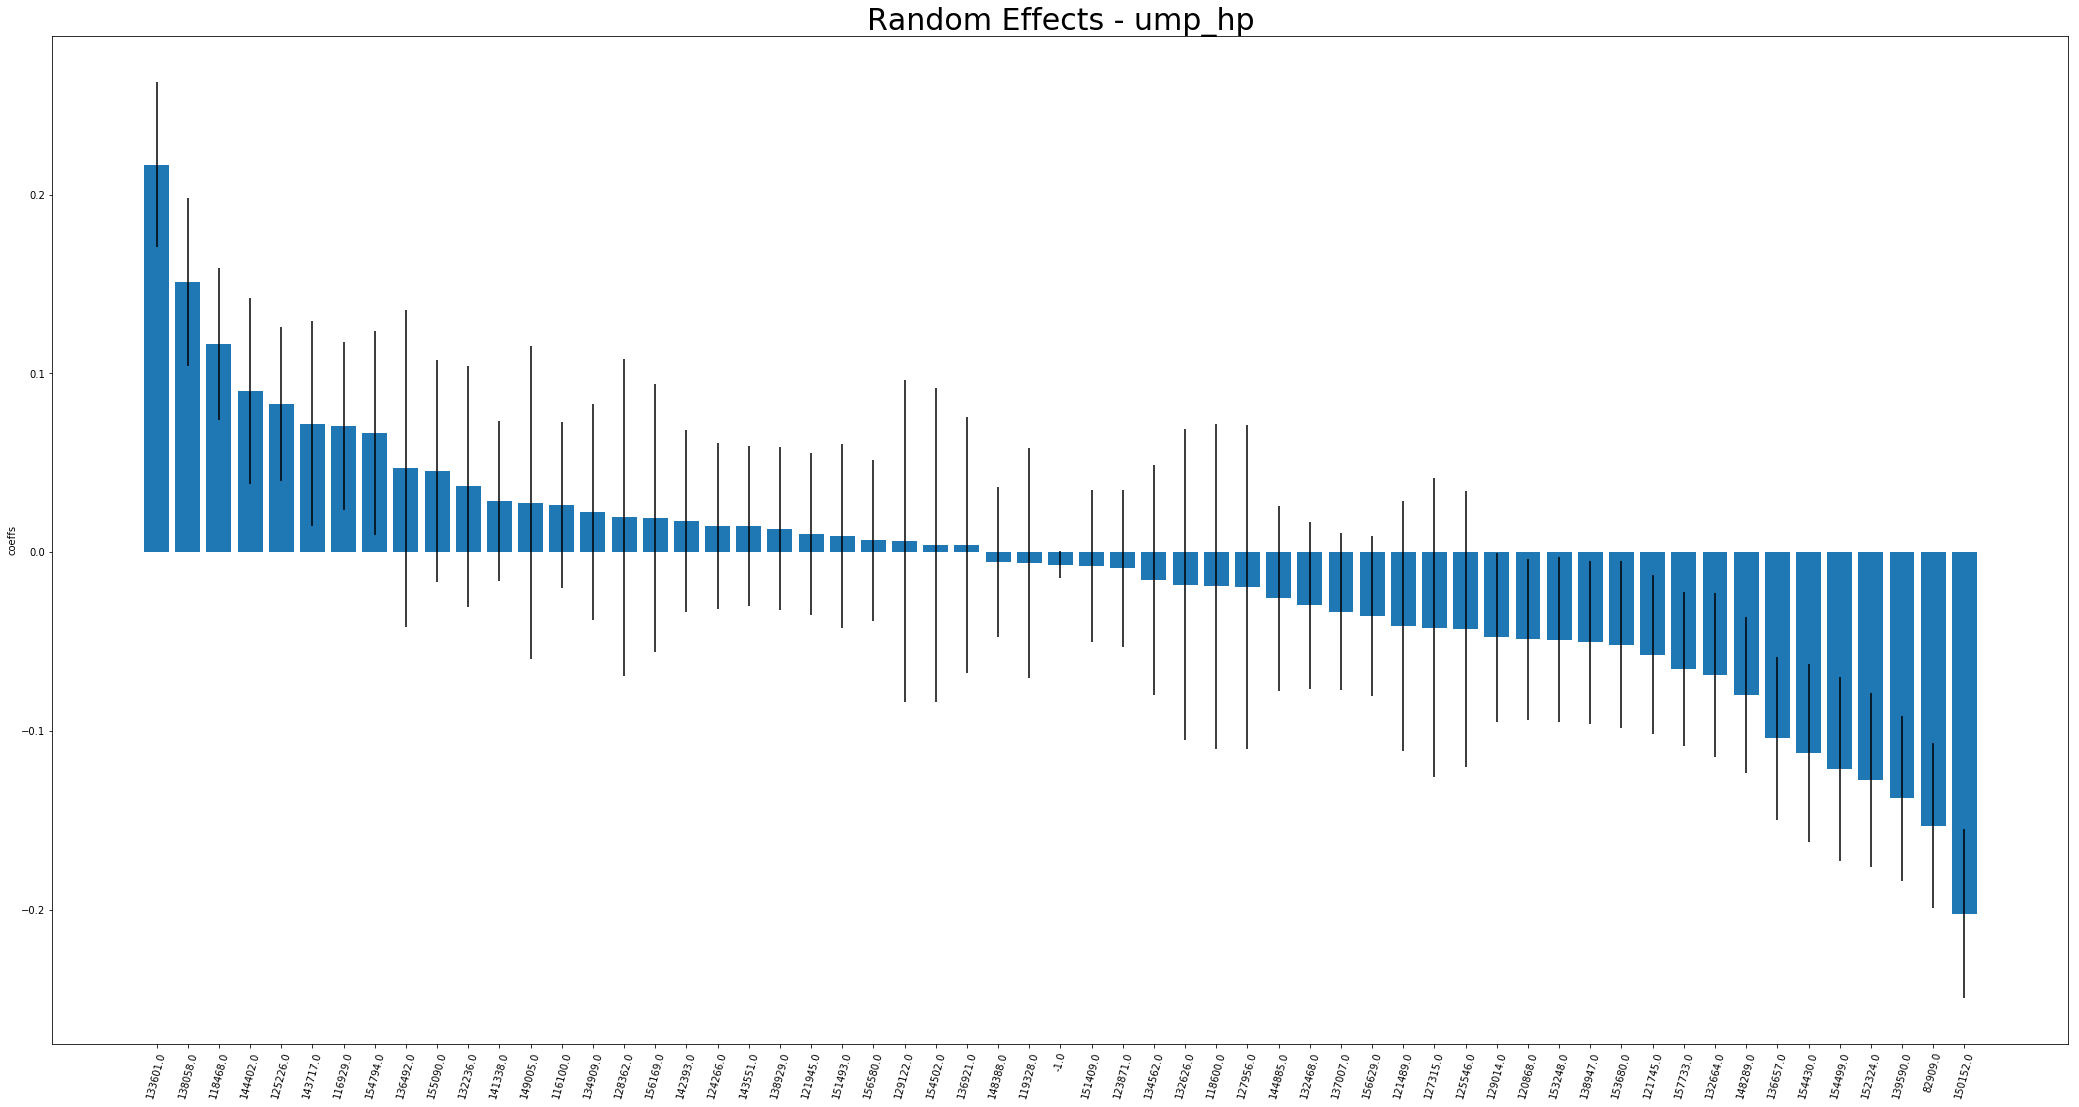

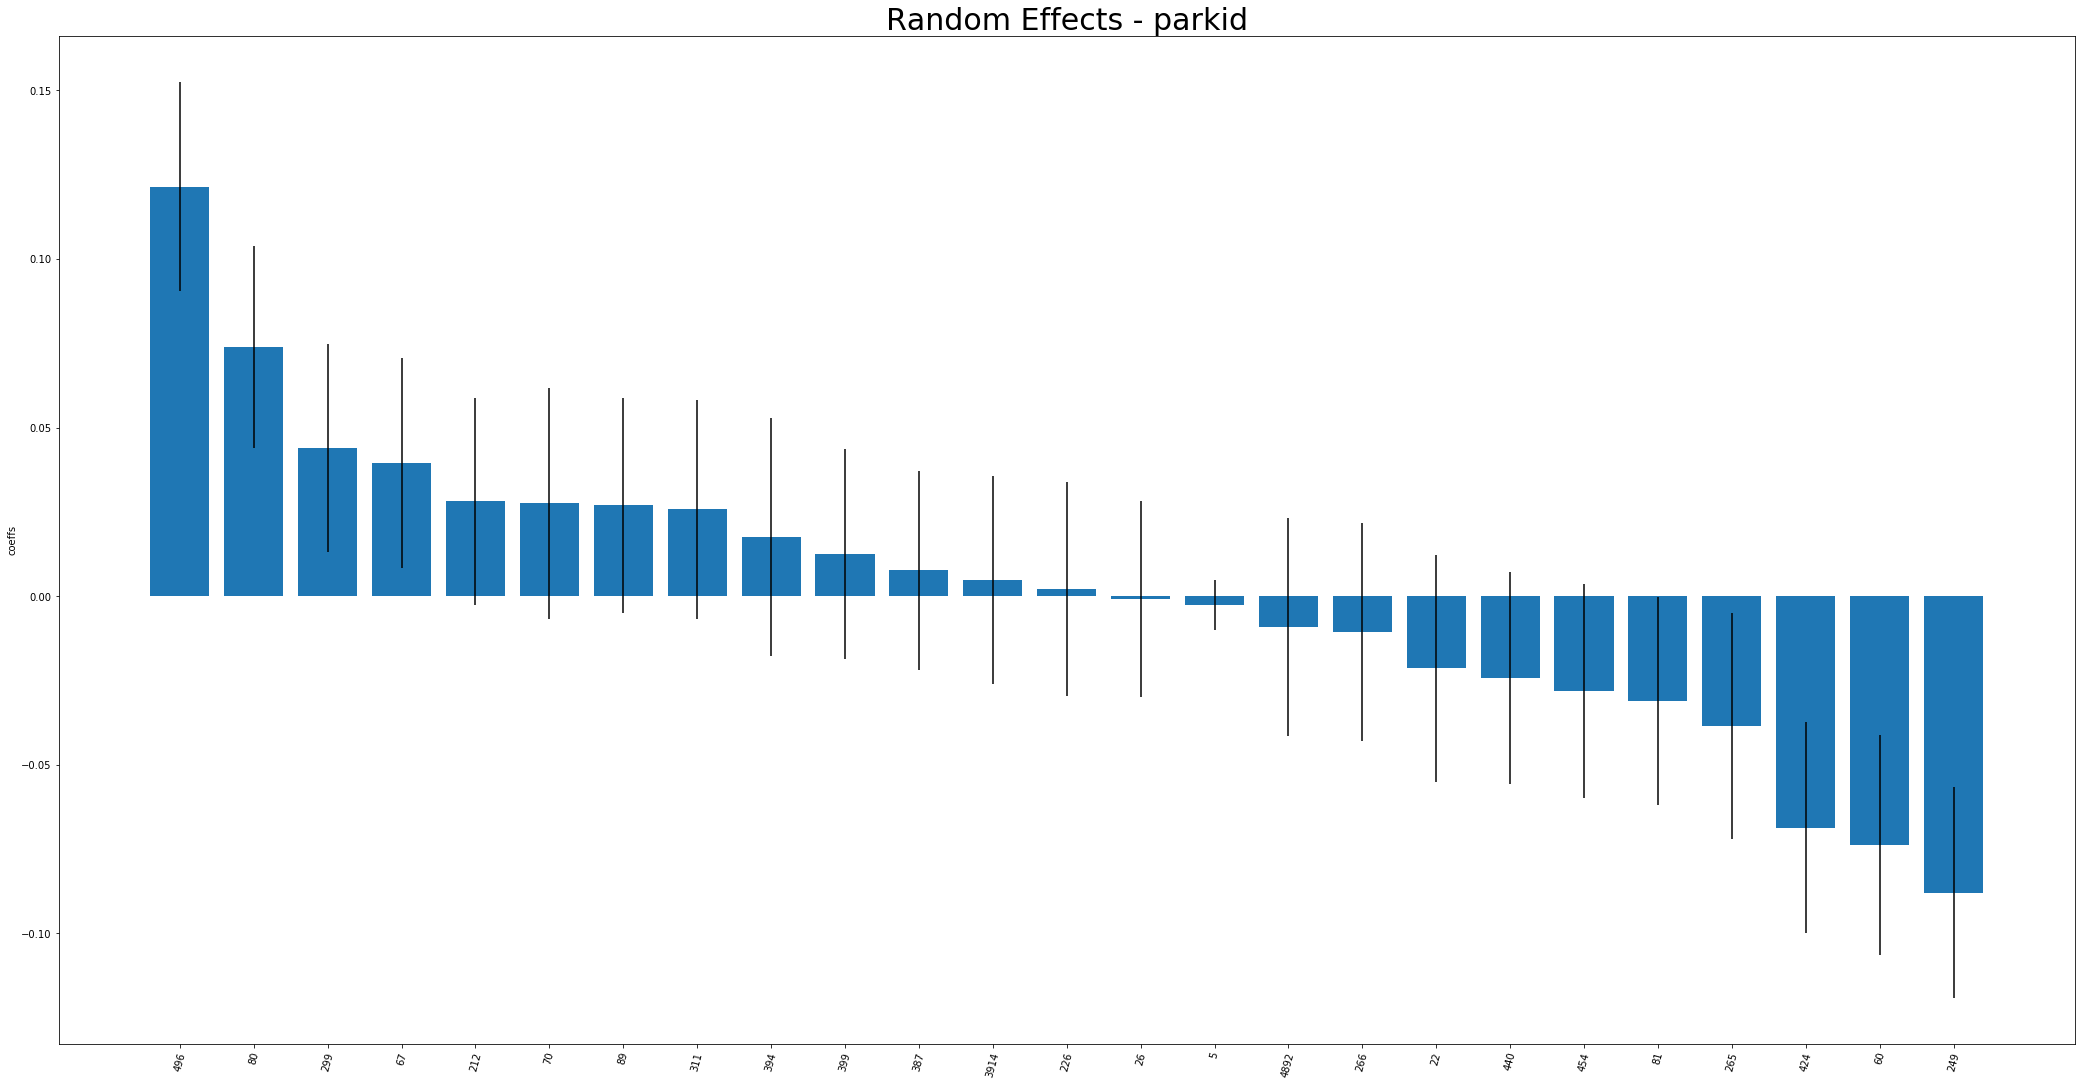

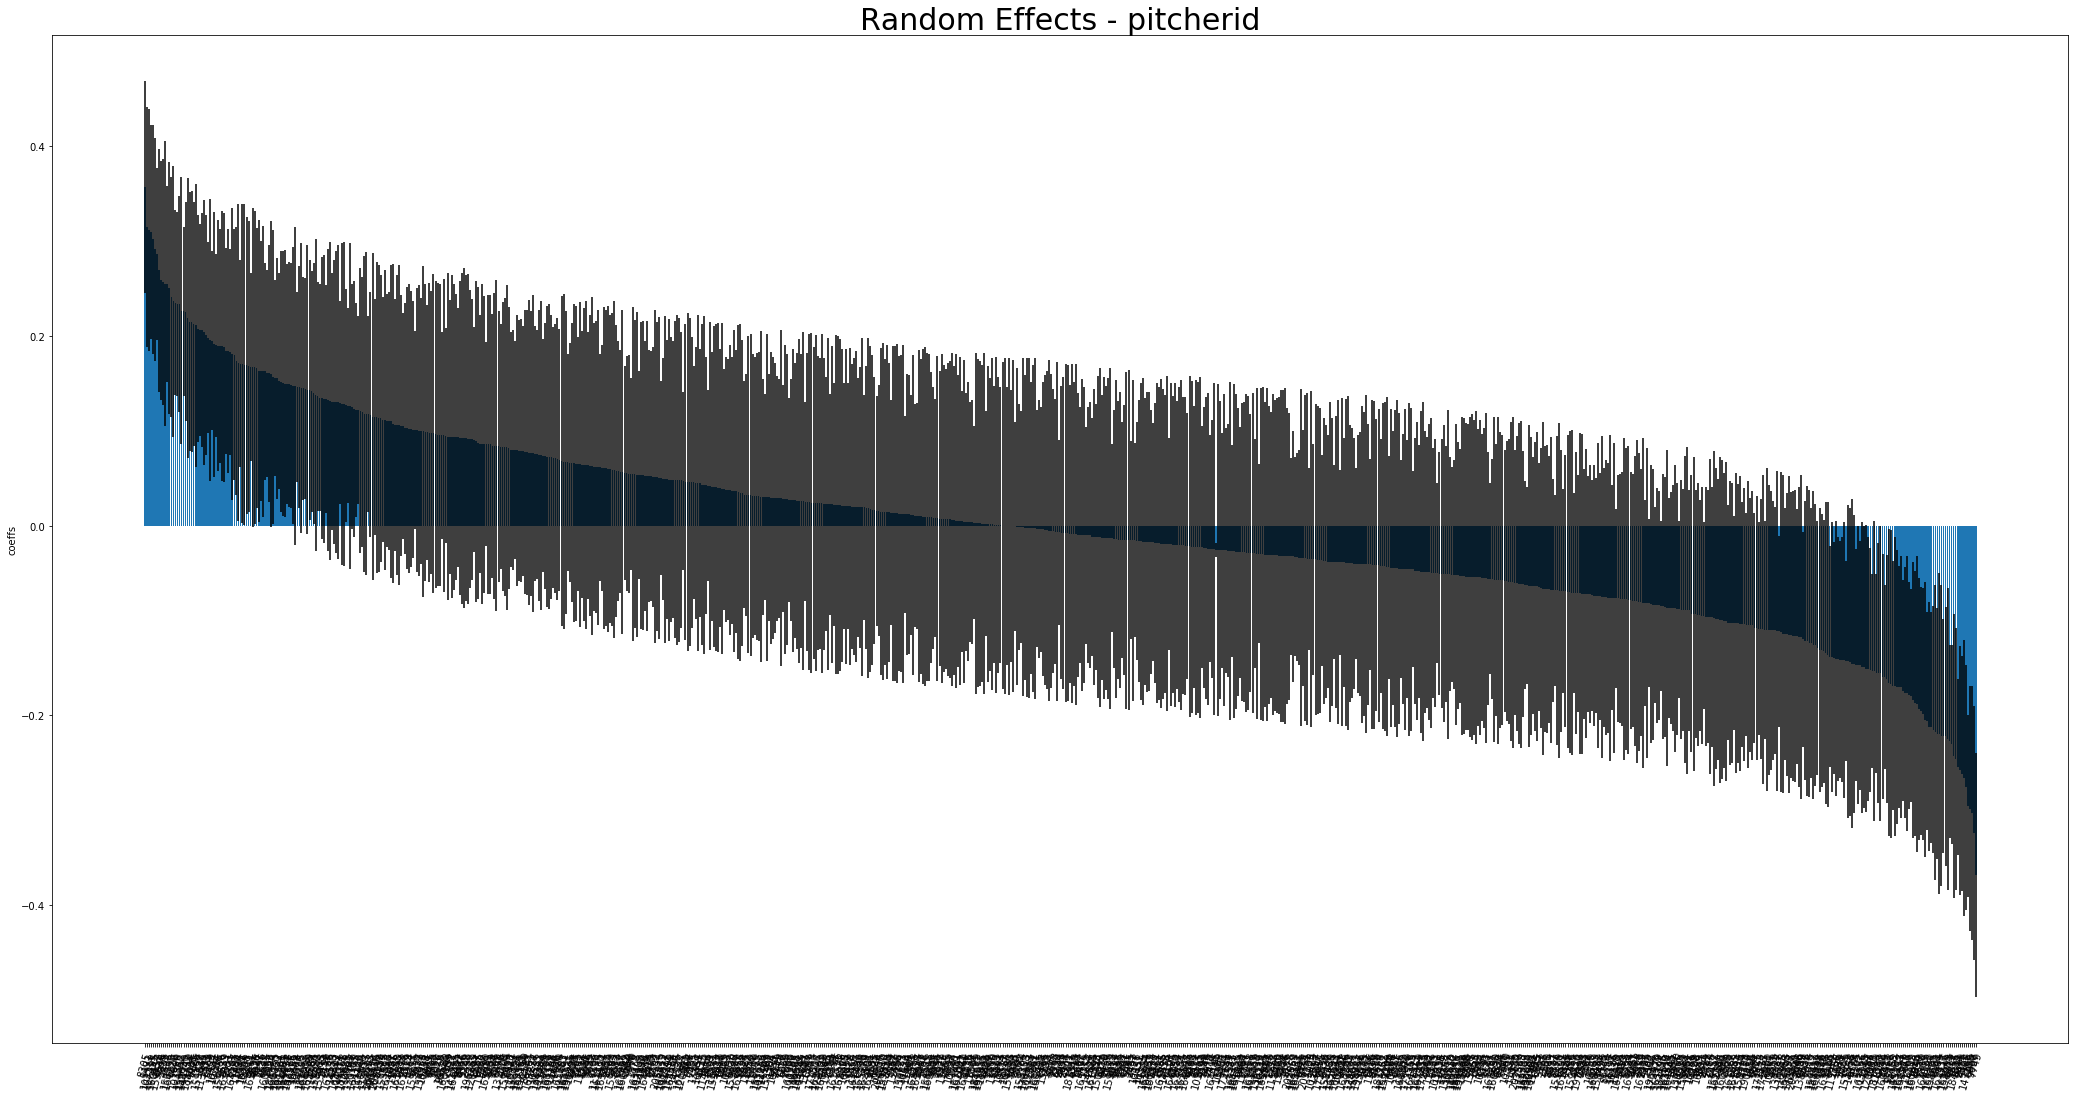

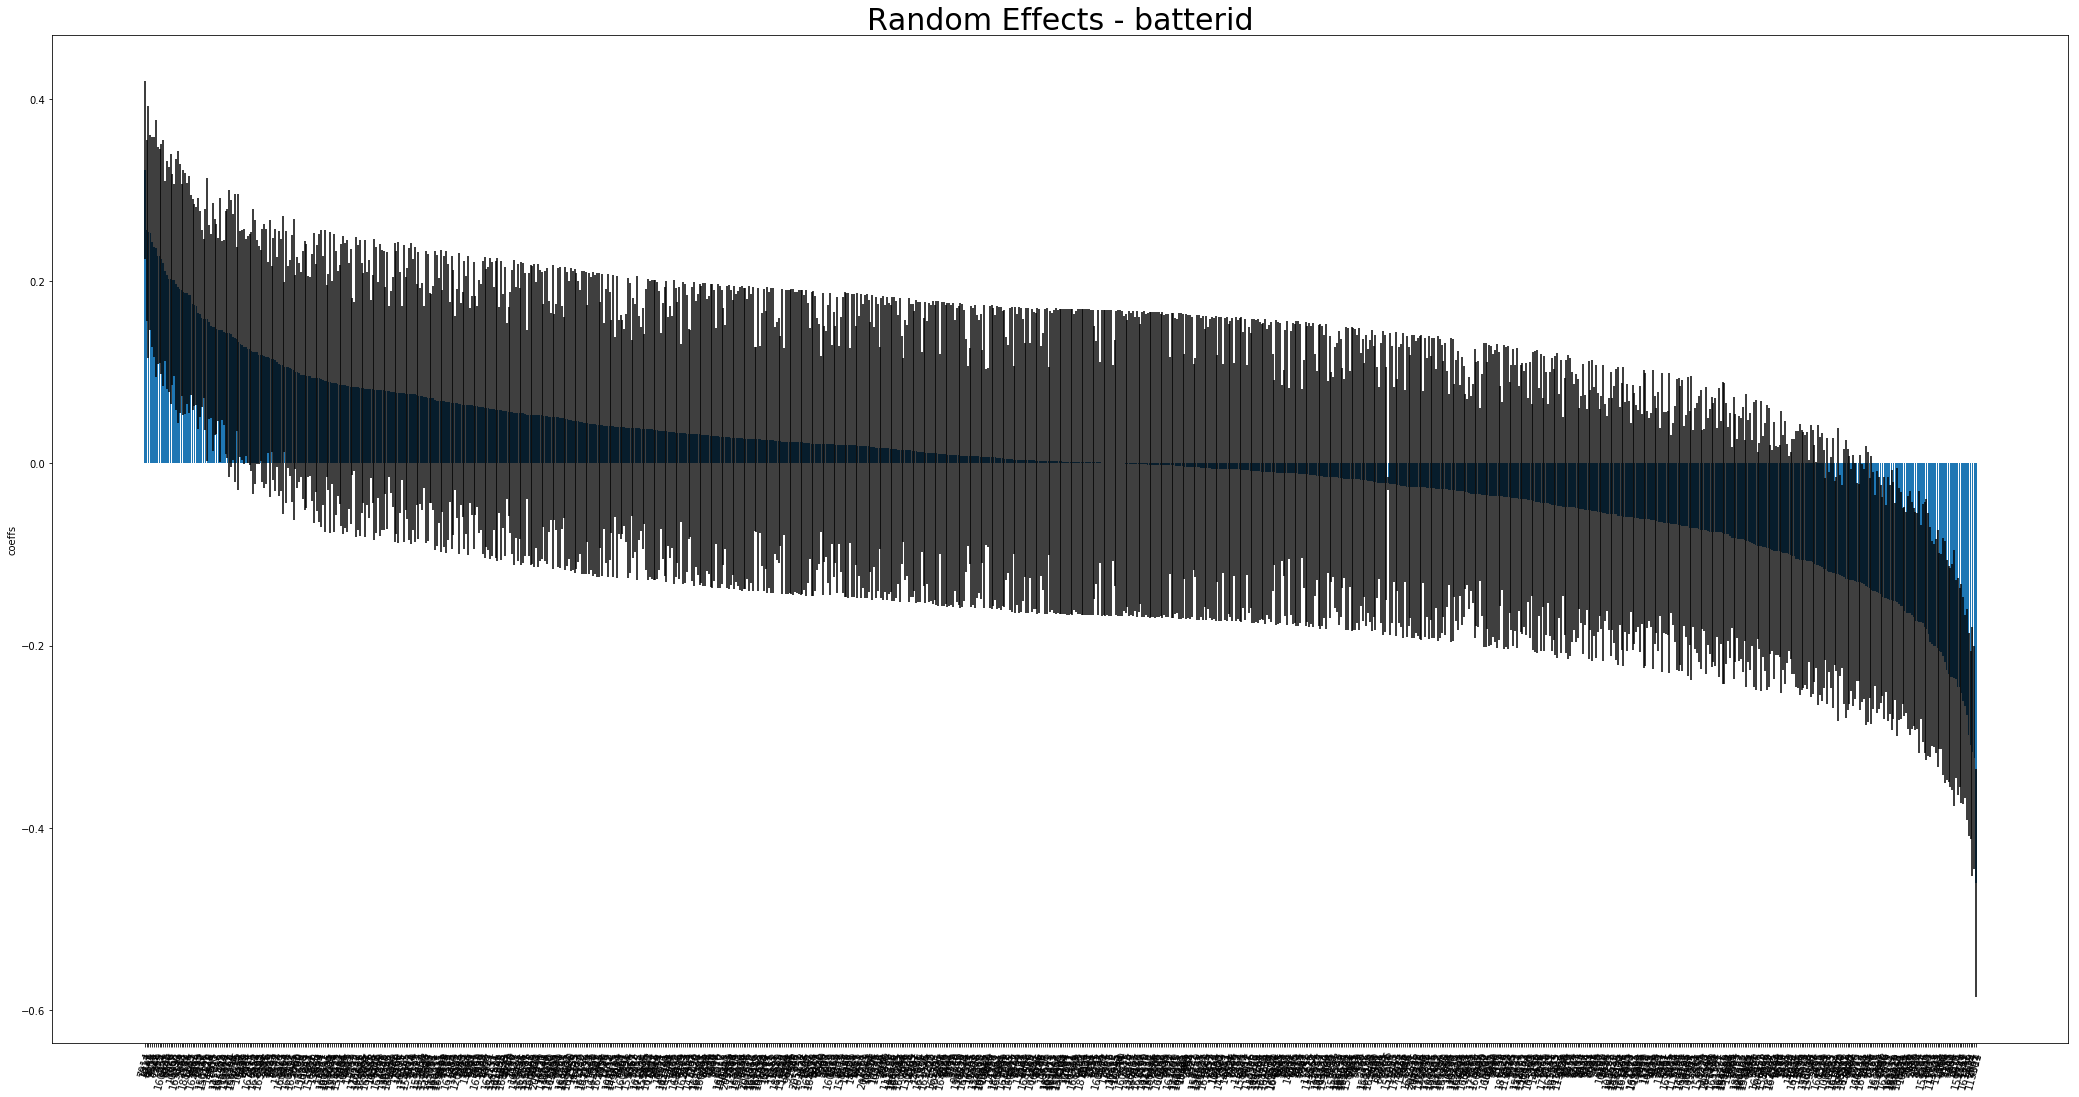

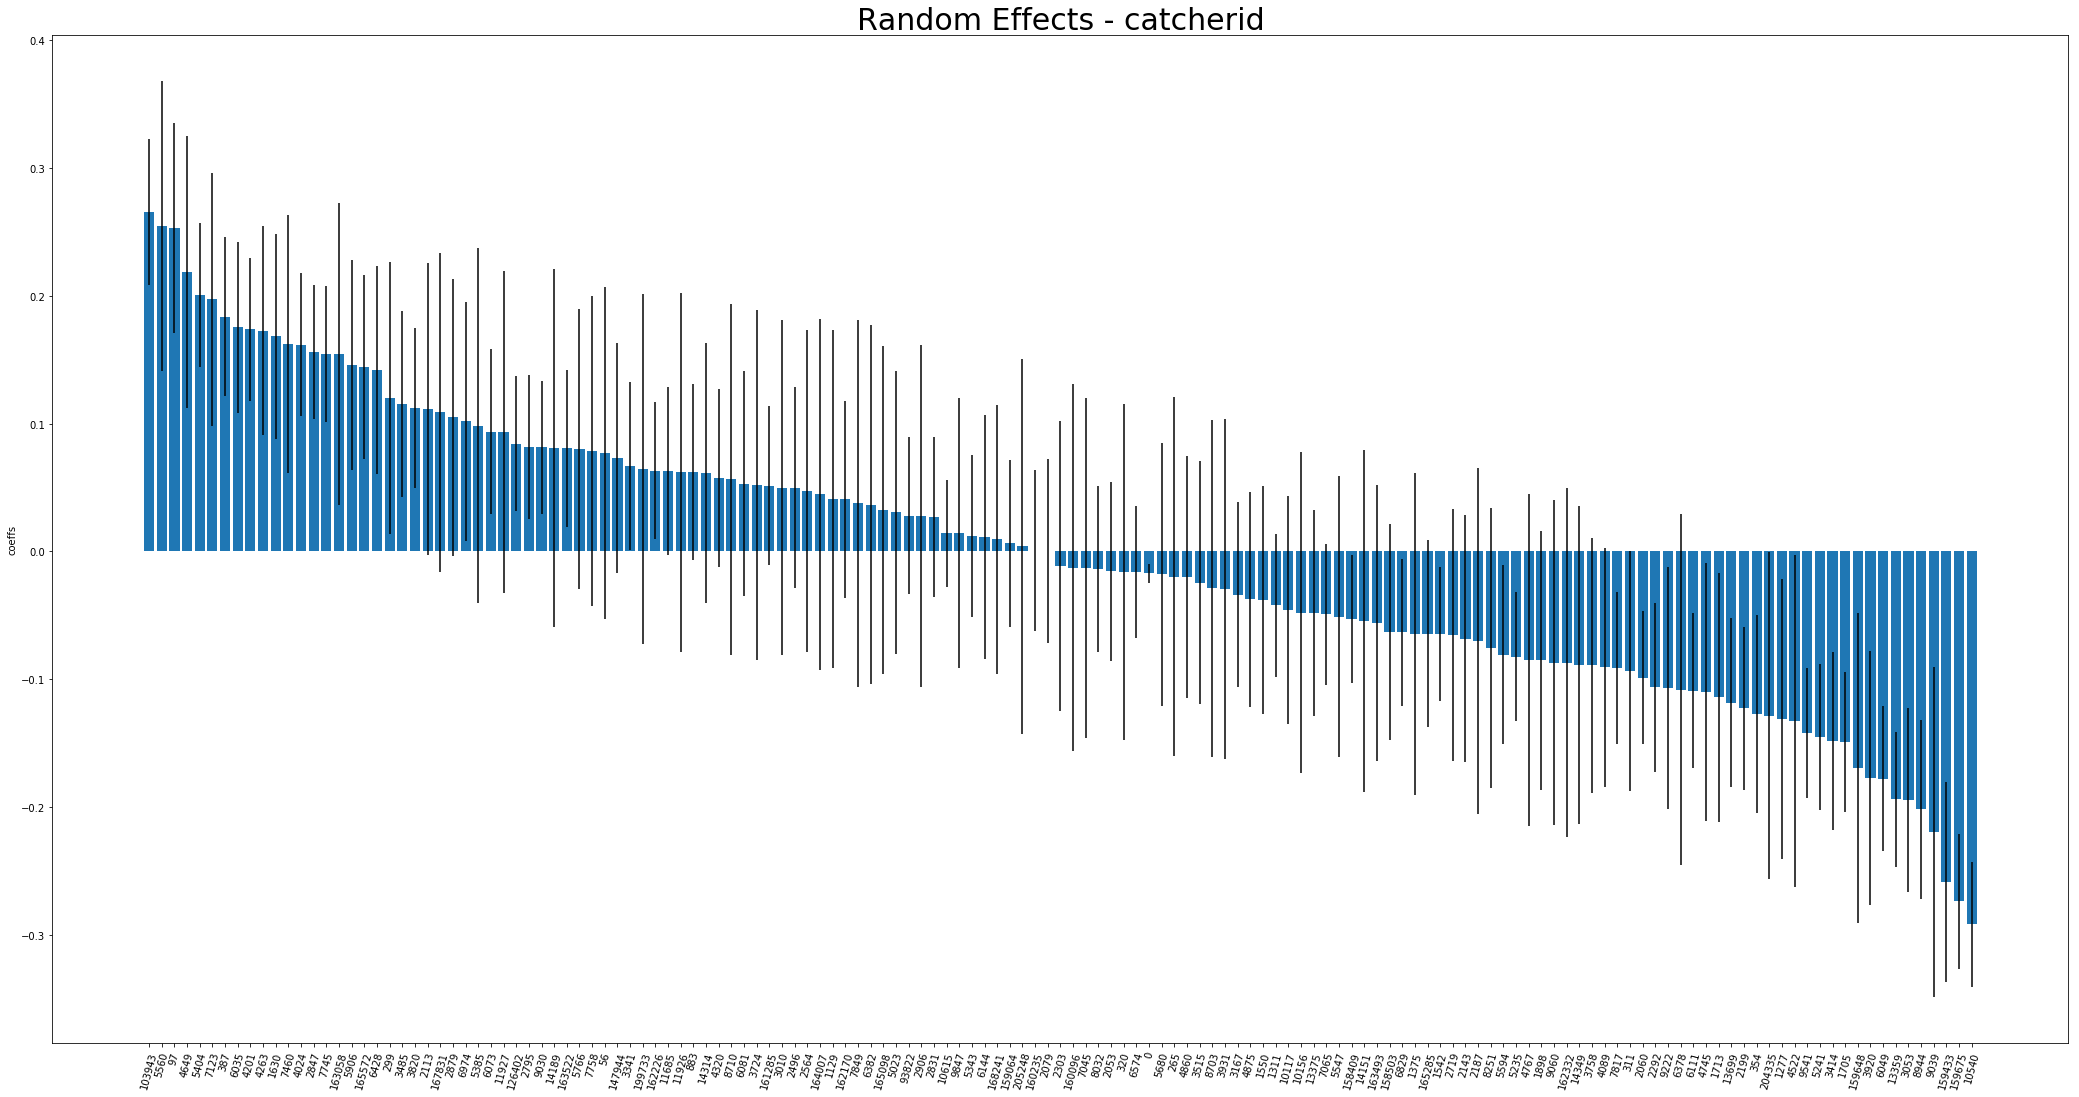

In [487]:
for effect in [
    'ump_hp','parkid','pitcherid','batterid','catcherid'
]:
    plot_effect_factors(effect, random)

In [ ]:
get_random_effect_factors('catcherid', random).sort_values('Mean',ascending=False)

In [503]:
np.mean(model.data.exog, axis=0)

array([1.        , 0.48777768, 0.31885167])

In [190]:
fixed_effect = np.matmul(np.mean(model.data.exog, axis=0),model_fitted.fe_mean)
baseline_prob = norm.cdf(fixed_effect)

In [179]:
fixed_effect

-1.1053535586713004

In [478]:
catchers = get_random_effect_factors('catcherid', random).sort_values('Mean',ascending=False)

                       Mean        SD
C(catcherid)[T.0] -0.017071  0.007539


In [479]:
def extract_id(df,id_name):
    return df[id_name].replace('C({})'.format(id_name),'')[3:-1]

In [480]:
catchers.reset_index(inplace=True)
catchers.rename(columns={'index':'catcherid'}, inplace=True)
catchers['catcherid'] = catchers.apply(extract_id, args=['catcherid'], axis=1)

In [481]:
def calc_random_effect_prob(df, sd_multiplier=0):
    z = df['Mean'] + (sd_multiplier * df['SD']) + fixed_effect
    return norm.cdf(z)

def calc_random_effect_prob_added(df, col):
    return df[col] - norm.cdf(fixed_effect)

In [482]:
catchers['prob'] = catchers.apply(calc_random_effect_prob, args=[0], axis=1)
catchers['CSAA'] = catchers.apply(calc_random_effect_prob_added, args=['prob'], axis=1)

In [483]:
catchers['prob_ub'] = catchers.apply(calc_random_effect_prob, args=[1], axis=1)
catchers['CSAA_ub'] = catchers.apply(calc_random_effect_prob_added, args=['prob_ub'], axis=1)
catchers['prob_lb'] = catchers.apply(calc_random_effect_prob, args=[-1], axis=1)
catchers['CSAA_lb'] = catchers.apply(calc_random_effect_prob_added, args=['prob_lb'], axis=1)

In [538]:
output = catchers.set_index('catcherid')[['CSAA','CSAA_lb','CSAA_ub']]
output.to_csv('catcher_framing_ratings.csv')

In [541]:
output

,CSAA,CSAA_lb,CSAA_ub
catcherid,,,
103943,0.065963,0.050352,0.082339
5560,0.062943,0.032973,0.095944
97,0.062535,0.040595,0.086061
4649,0.053139,0.025883,0.083085
5404,0.048269,0.033666,0.063639
7123,0.047424,0.022498,0.074687
387,0.043841,0.028098,0.060510
6035,0.041669,0.024903,0.059510
4201,0.041302,0.027200,0.056159
